<a href="https://colab.research.google.com/github/Samia1925/Online-Course-Engagement-Prediction/blob/main/ProjectWithKNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## data preprocessing

### importing all libraries

In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

### Load the data

In [2]:
# Loading and preprocessing data
df = pd.read_csv("online_course_engagement_data.csv")

### checking mssing values

In [3]:
missing_data= df.isnull().sum()
print("missing data: \n", missing_data)

missing data: 
 UserID                   0
CourseCategory           0
TimeSpentOnCourse        0
NumberOfVideosWatched    0
NumberOfQuizzesTaken     0
QuizScores               0
CompletionRate           0
DeviceType               0
CourseCompletion         0
dtype: int64


### Handle categorical variable: CourseCategory

In [4]:
# Encoding categorical variable
label_encoder = LabelEncoder()
df['CourseCategory'] = label_encoder.fit_transform(df['CourseCategory'])

### Define features and target

In [5]:
# Defining features and target
X = df.drop(['UserID', 'CourseCompletion', 'CourseCategory', 'DeviceType'], axis=1)
# X = df.drop(['UserID', 'CourseCompletion'], axis=1)
y = df['CourseCompletion']

### Boxplot to detect outliers for each feature

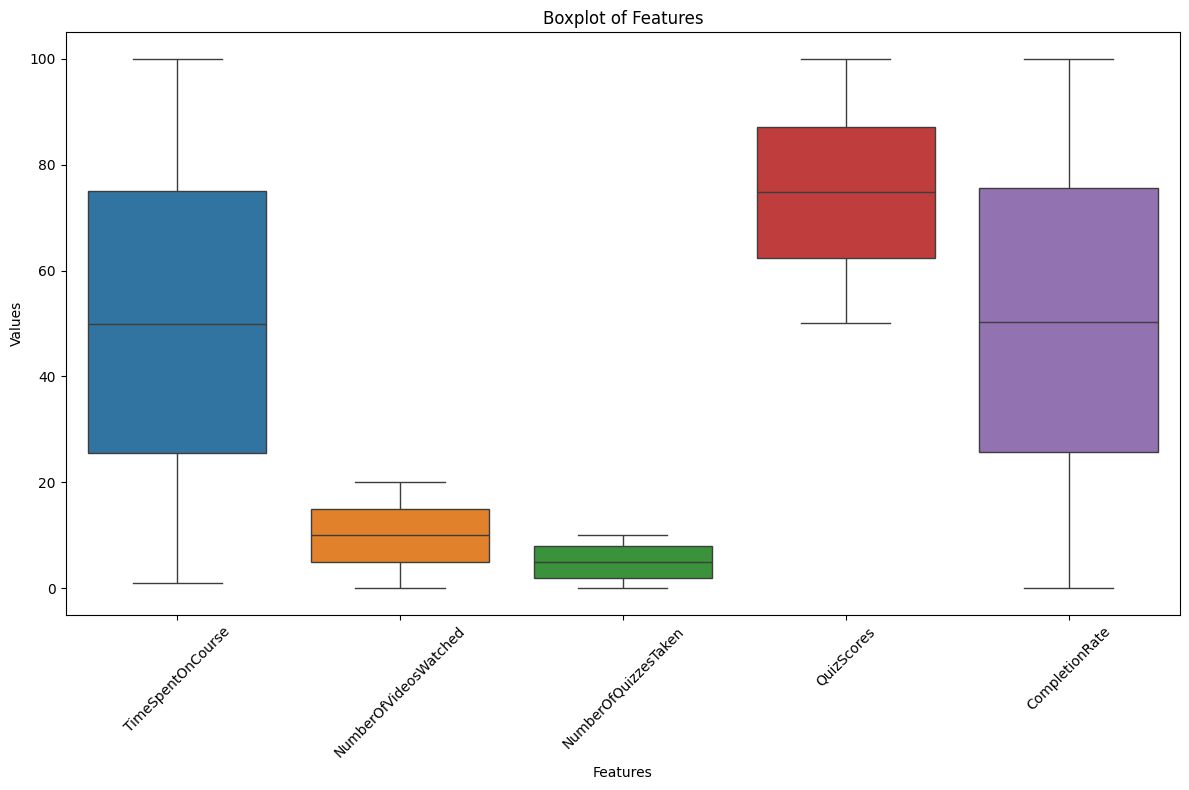

In [6]:
# Creating boxplot for feature distribution
plt.figure(figsize=(12, 8))
sns.boxplot(data=X)
plt.title('Boxplot of Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('boxplot_outliers.png')

### Check for class imbalance

In [7]:
# Displaying original class distribution
print("Class distribution:", y.value_counts(normalize=True))

Class distribution: CourseCompletion
0    0.603556
1    0.396444
Name: proportion, dtype: float64


### Split data into training and testing sets

In [8]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Scaling features

In [9]:
# Scaling features for k-NN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Handle Imabalance Data with SMOTE

In [10]:
# Applying SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print("Balanced class distribution after SMOTE:\n", y_train_smote.value_counts(normalize=True))

Balanced class distribution after SMOTE:
 CourseCompletion
0    0.5
1    0.5
Name: proportion, dtype: float64


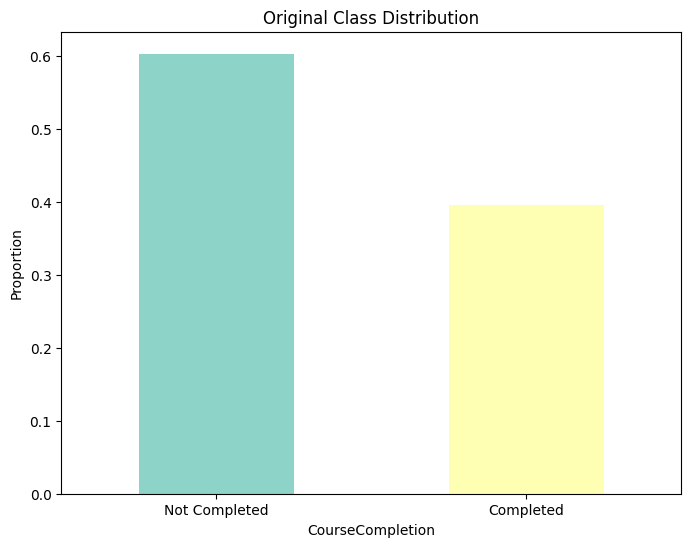

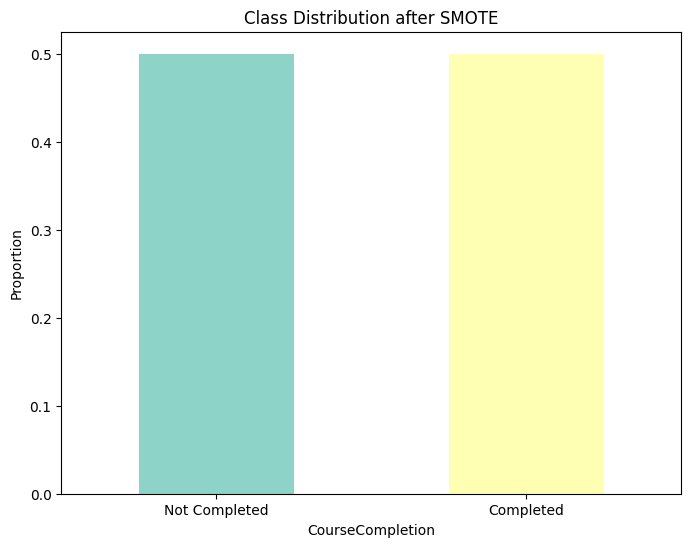

In [11]:
# Getting Set3 colors for visualization
set3_colors = cm.Set3(range(2))

# Plotting original class distribution
plt.figure(figsize=(8, 6))
pd.Series(y).value_counts(normalize=True).plot(kind='bar', color=set3_colors)
plt.title('Original Class Distribution')
plt.xlabel('CourseCompletion')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['Not Completed', 'Completed'], rotation=0)
plt.savefig('original_class_distribution.png')

# Plotting class distribution after SMOTE
plt.figure(figsize=(8, 6))
pd.Series(y_train_smote).value_counts(normalize=True).plot(kind='bar', color=set3_colors)
plt.title('Class Distribution after SMOTE')
plt.xlabel('CourseCompletion')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['Not Completed', 'Completed'], rotation=0)
plt.savefig('smote_class_distribution.png')

## prediction using KNN

### Hyperparameter tuning with GridSearchCV

In [12]:
# Defining hyperparameter grid for k-NN
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 15, 17, 19, 21, 23, 25, 50, 75, 100, 125, 150],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initializing k-NN Classifier
knn_classifier = KNeighborsClassifier()

# Performing GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 15, 17, 19, 21, 23, 25, 50,
                                         75, 100, 125, 150],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

### Best model

In [13]:
# Getting the best model
best_knn = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
Best cross-validation score: 0.9285565491059702


### Make predictions

In [14]:
# Making predictions on the test set
y_pred = best_knn.predict(X_test_scaled)
y_pred_proba = best_knn.predict_proba(X_test_scaled)[:, 1]

## Evaluation of the model

### Print evaluation metrics

In [15]:
# Calculating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")


Accuracy: 0.92
ROC-AUC: 0.96


In [16]:
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1086
           1       0.89      0.91      0.90       714

    accuracy                           0.92      1800
   macro avg       0.91      0.92      0.91      1800
weighted avg       0.92      0.92      0.92      1800



### Confusion matrix heatmap

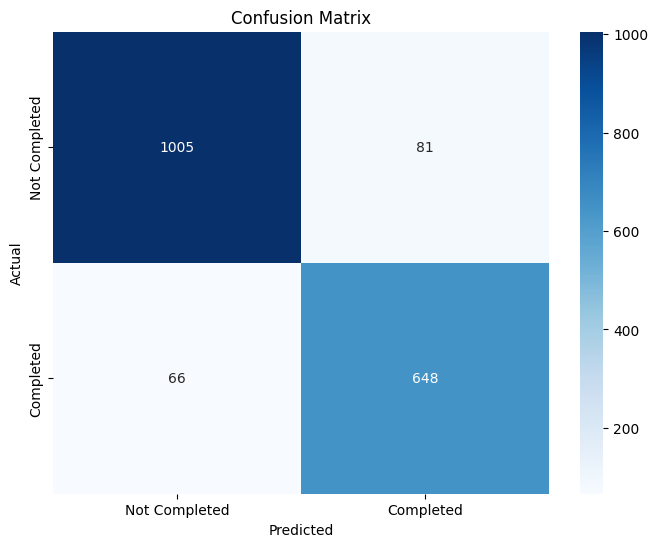

In [17]:
# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Not Completed', 'Completed'],
            yticklabels=['Not Completed', 'Completed'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')

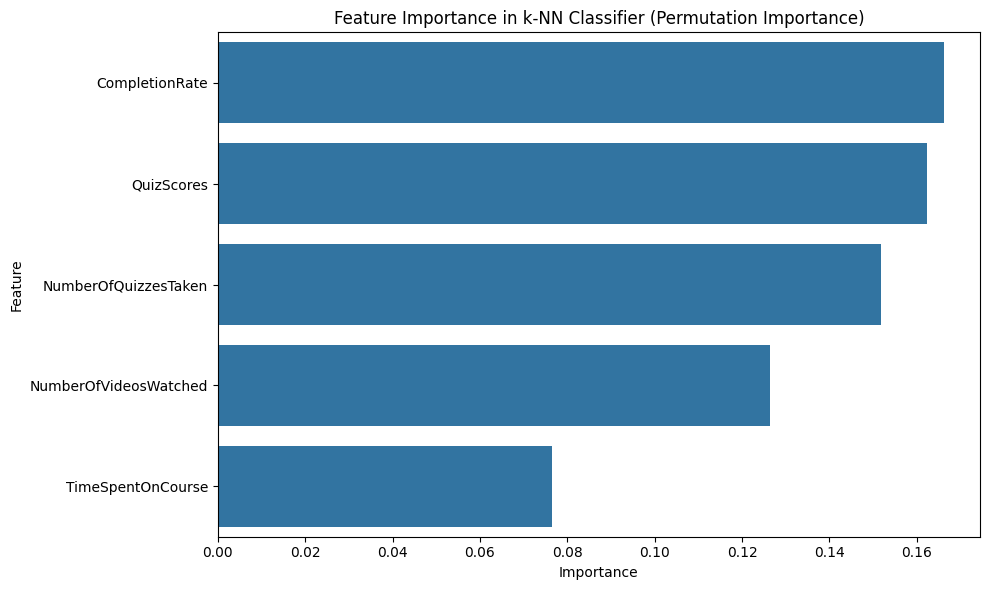

In [18]:
# Calculating feature importance using permutation importance
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(best_knn, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Creating feature importance DataFrame
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_importance.importances_mean
}).sort_values('importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in k-NN Classifier (Permutation Importance)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importance.png')

## prediction on demo data

In [19]:
# Function to predict course completion for new data
def predict_course_completion(new_data, model, label_encoder, scaler):
    # new_data['CourseCategory'] = label_encoder.transform(new_data['CourseCategory'])
    new_data = new_data.drop(['UserID'], axis=1, errors='ignore')
    new_data_scaled = scaler.transform(new_data)
    prediction = model.predict(new_data_scaled)
    return prediction

In [20]:
# Example usage of prediction function
example_data = pd.DataFrame({
    'UserID': [9999],
    # 'CourseCategory': ['Health'],
    'TimeSpentOnCourse': [50.0],
    'NumberOfVideosWatched': [10],
    'NumberOfQuizzesTaken': [5],
    'QuizScores': [75.0],
    'CompletionRate': [80.0]
    # 'DeviceType': [1]
})

In [21]:
prediction = predict_course_completion(example_data, best_knn, label_encoder, scaler)
print(f"\nPrediction for example data: {'Completed' if prediction[0] == 1 else 'Not Completed'}")


Prediction for example data: Completed


Optimal k from elbow plot: 6

Accuracy with k=6: 0.90
ROC-AUC: 0.94

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1086
           1       0.87      0.89      0.88       714

    accuracy                           0.90      1800
   macro avg       0.90      0.90      0.90      1800
weighted avg       0.90      0.90      0.90      1800



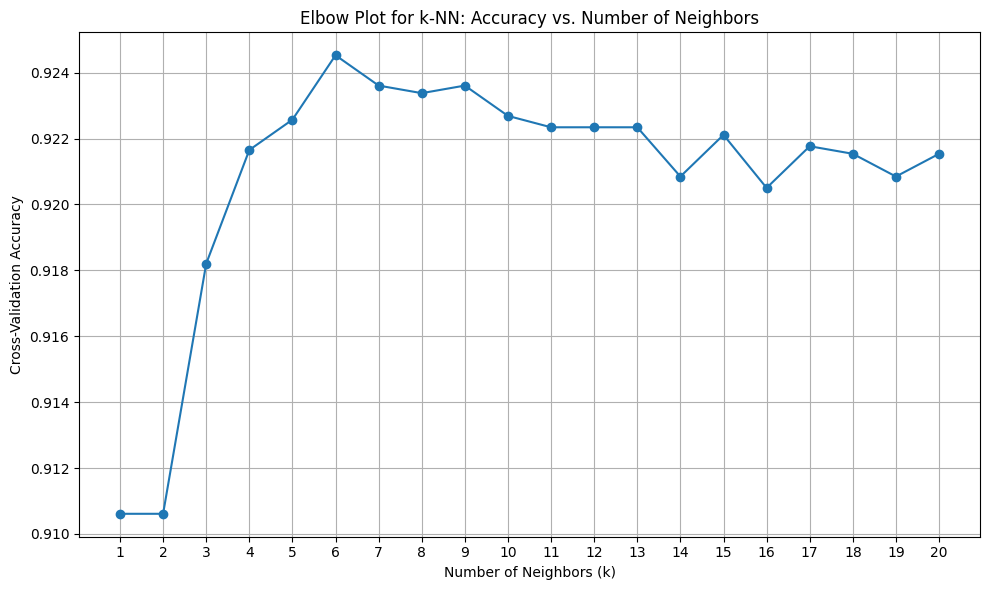

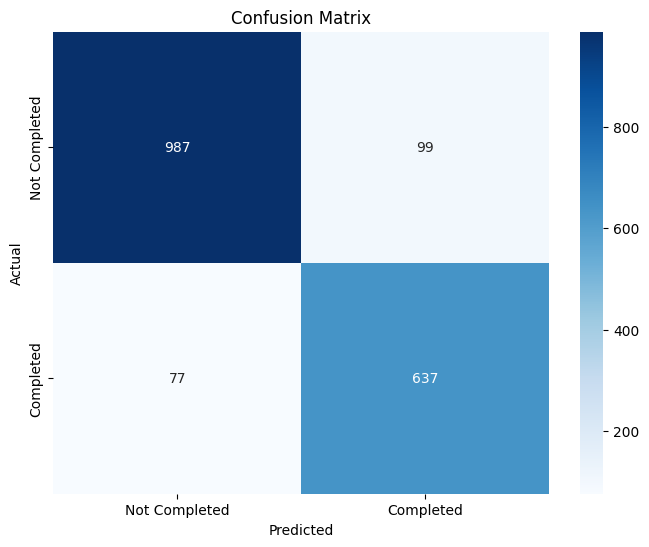

In [22]:
from sklearn.model_selection import train_test_split, cross_val_score

# Elbow plot for selecting optimal k
k_range = range(1, 21)  # Testing k from 1 to 20
cv_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')
    scores = cross_val_score(knn, X_train_smote, y_train_smote, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, cv_scores, marker='o')
plt.title('Elbow Plot for k-NN: Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.grid(True)
plt.xticks(k_range)
plt.tight_layout()
plt.savefig('elbow_plot.png')

# Finding the optimal k
optimal_k = k_range[np.argmax(cv_scores)]
print(f"Optimal k from elbow plot: {optimal_k}")

# Training k-NN with the optimal k
knn_classifier = KNeighborsClassifier(n_neighbors=optimal_k, weights='distance', metric='euclidean')
knn_classifier.fit(X_train_smote, y_train_smote)

# Making predictions on the test set
y_pred = knn_classifier.predict(X_test_scaled)
y_pred_proba = knn_classifier.predict_proba(X_test_scaled)[:, 1]

# Calculating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"\nAccuracy with k={optimal_k}: {accuracy:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

print("\nClassification Report:")
print(class_report)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Not Completed', 'Completed'],
            yticklabels=['Not Completed', 'Completed'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')



In [23]:
# Function to predict course completion for new data
def predict_course_completion(new_data, model, label_encoder, scaler):
    new_data = new_data.drop(['UserID'], axis=1, errors='ignore')
    new_data_scaled = scaler.transform(new_data)
    prediction = model.predict(new_data_scaled)
    return prediction

# Example usage of prediction function
example_data = pd.DataFrame({
    'UserID': [9999],
    'TimeSpentOnCourse': [50.0],
    'NumberOfVideosWatched': [10],
    'NumberOfQuizzesTaken': [5],
    'QuizScores': [75.0],
    'CompletionRate': [80.0]
})

prediction = predict_course_completion(example_data, knn_classifier, label_encoder, scaler)
print(f"\nPrediction for example data: {'Completed' if prediction[0] == 1 else 'Not Completed'}")


Prediction for example data: Completed
